In [2]:
import rebound
from ctypes import byref
from ctypes import c_double as double
import numpy as np
import matplotlib.pyplot as plt
import rebound.data as data
c = rebound.clibrebound

def kepler_operator(r, dt):
    dt = double(dt)
    c.reb_integrator_whfast_from_inertial(r);
    c.reb_whfast_com_step(r,dt);
    c.reb_whfast_kepler_step(r,dt);
    c.reb_integrator_whfast_to_inertial(r);

def interaction_operator(r, dt):
    dt = double(dt)
    c.reb_integrator_whfast_to_inertial(r);
    c.reb_simulation_update_acceleration(r);
    c.reb_whfast_interaction_step(r,dt);
    
# [H_i,[H_i,H_k]]
def commutator_i_i_k(r,dt):
    ei = sim.energy();
    kepler_operator(r,dt/2.);
    interaction_operator(r,dt);
    kepler_operator(r,-dt/2.);
    interaction_operator(r,-dt);
    interaction_operator(r,dt); 
    interaction_operator(r,dt);
    kepler_operator(r,dt/2.);
    interaction_operator(r,-dt);
    kepler_operator(r,-dt/2.);
    interaction_operator(r,-dt);
    ef = sim.energy();
    return (np.abs(ef-ei)/np.abs(ei))/12.

# [H_k,[H_k,H_i]]
def commutator_k_k_i(r,dt):
    ei = sim.energy();
    interaction_operator(r,dt)
    kepler_operator(r,dt/2.)
    interaction_operator(r,-dt)
    kepler_operator(r,-dt/2.)
    kepler_operator(r,dt/2.)
    kepler_operator(r,dt/2.)
    interaction_operator(r,dt)
    kepler_operator(r,-dt/2.)
    interaction_operator(r,-dt)
    kepler_operator(r,-dt/2.)
    ef = sim.energy()
    return (np.abs(ef-ei)/np.abs(ei))/24.

def init_particles(sim):
    # sim.add(m=1.)
    # sim.add(m=1.,a=1.)
    data.add_outer_solar_system(sim)
    #data.add_solar_system(sim)

sim = rebound.Simulation()
sim.integrator= "whfast"
sim.ri_whfast.coordinates = "barycentric"
sim.ri_whfast.corrector = 0
r = byref(sim)
init_particles(sim)
p = sim.particles[1].P
dt = p/1000.
t_final = 1000*p
print("dt: ",dt)
times = np.arange(0,t_final,dt)
energy = np.zeros(len(times))
iik = np.zeros(len(times))
kki = np.zeros(len(times))
ei = sim.energy()
for i,t in enumerate(times):
    sim.integrate(t)
    iik[i] = commutator_i_i_k(r,dt)
    kki[i] = commutator_k_k_i(r,dt)
    #p = sim.particles[1].P
    energy[i] = np.abs(sim.energy()-ei)/np.abs(ei)

dt:  0.07456162171191812


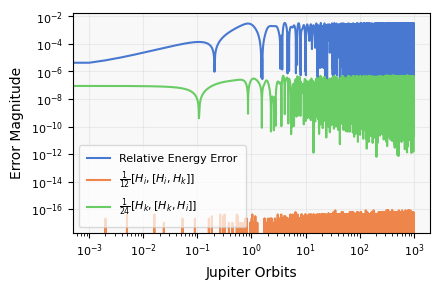

In [3]:
# Reset to default style with white background
plt.style.use('default')
# Reduce width for two-column layout (width between 3.3-4.5 inches works well)
fig = plt.figure(figsize=(4.5, 3))  # Adjusted for two-column format

# Create more professional, subdued color scheme
colors = ['#4878D0', '#EE854A', '#6ACC64']  # Muted blue, orange, green

# Plot with refined styling
plt.plot(times/p, energy, label="Relative Energy Error", color=colors[0], linewidth=1.5)
plt.plot(times/p, iik, label=r"$\frac{1}{12}[H_i,[H_i,H_k]]$", color=colors[1], linewidth=1.5)
plt.plot(times/p, kki, label=r"$\frac{1}{24}[H_k,[H_k,H_i]]$", color=colors[2], linewidth=1.5)

# Add subtle grid
plt.grid(alpha=0.3, linestyle='-', color='#CCCCCC')

# Log scales
plt.yscale('log')
plt.xscale('log')

# Typography improvements - reduced font sizes for two-column format
#plt.title("Barycentric Commutators", fontsize=12, fontweight='bold', pad=10)
plt.xlabel("Jupiter Orbits", fontsize=10, labelpad=5)
plt.ylabel("Error Magnitude", fontsize=10, labelpad=5)

# Better legend with smaller text
plt.legend(loc="lower left", fontsize=8, framealpha=0.7, 
           fancybox=True, borderpad=0.8)

# Improve appearance
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()

# Add subtle background shading for visual appeal
ax = plt.gca()
ax.set_facecolor('#F8F8F8')
fig.patch.set_facecolor('white')

plt.show()
# For vector graphics in LaTeX, PDF is better than bitmap formats
# Lower DPI is fine for PDF since it's vector-based
fig.savefig("commutators.pdf", dpi=150, bbox_inches='tight')